In [1]:
import pandas as pd
from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta
# 판다스 엑셀 익스포트를 위한 라이브러리
import openpyxl


PROJECT = "ballosodeuk"
bq = bigquery.Client(project=PROJECT)

In [31]:
query = """
  WITH first_purchase AS (
    SELECT 
      user_id,
      MIN(register_dt) AS first_purchase_date
    FROM `dm.agg_user_cash_daily`
    WHERE purchase IS NOT NULL
    GROUP BY user_id
  ),

  second_purchase AS (
    SELECT 
      a.user_id,
      MIN(a.register_dt) AS second_purchase_date
    FROM `dm.agg_user_cash_daily` a
    JOIN first_purchase fp ON a.user_id = fp.user_id
    WHERE a.purchase IS NOT NULL
      AND a.register_dt > fp.first_purchase_date
    GROUP BY a.user_id
  ),

  final AS (
    SELECT DISTINCT 
      a.user_id,
      date_diff (current_date(), join_dt, day) as join_dt,
      b.register_dt AS p_date,
      b.current_shoji AS cur_shoji,
      b.current_cash AS cur_cash,
      b.pre_shoji AS pre_shoji,
      b.pre_cash AS pre_cash,
      b.purchase AS p_amt,
      b.spend_use - b.earn_recall - b.spend_burnt AS s_amt,
      ROUND(
        (b.spend_use - b.earn_recall - b.spend_burnt) / NULLIF(b.purchase, 0)
      , 2) AS s_rto,
      SUM(a.earn_exchange) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS earn_exchange,
      COUNT(a.earn_exchange) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS earn_exchange_cnt,
      SUM(a.earn_reward) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS earn_reward,
      COUNT(a.earn_reward) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS since_visit_dt,
      COUNT(CASE WHEN a.earn_reward > 0 THEN a.earn_reward END) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS earn_reward_cnt
    FROM `dm.agg_user_cash_daily` a
    JOIN first_purchase fp ON a.user_id = fp.user_id
    JOIN `dm.agg_user_cash_daily` b 
      ON a.user_id = b.user_id 
      AND b.register_dt = fp.first_purchase_date
    JOIN `dw.dim_airbridge_member` c 
      ON a.user_id = c.user_id
    WHERE a.register_dt <= fp.first_purchase_date
      AND b.purchase IS NOT NULL
      AND c.join_dt < "2024-12-31"
  ),

  second_purchase_data AS (
    SELECT DISTINCT 
      a.user_id,
      s.second_purchase_date,
      b.current_shoji AS second_cur_shoji,
      b.pre_shoji AS second_pre_shoji,
      b.pre_cash AS second_pre_cash,
      b.purchase AS second_p_amt,
      b.spend_use - b.earn_recall - b.spend_burnt AS second_s_amt,
      ROUND(
        (b.spend_use - b.earn_recall - b.spend_burnt) / NULLIF(b.purchase, 0)
      , 2) AS second_s_rto,
      SUM(a.earn_exchange) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_earn_exchange,
      COUNT(a.earn_exchange) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_earn_exchange_cnt,
      SUM(a.earn_reward) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_earn_reward,
      COUNT(a.earn_reward) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_since_visit_dt,
      COUNT(CASE WHEN a.earn_reward > 0 THEN a.earn_reward END) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_earn_reward_cnt
    FROM `dm.agg_user_cash_daily` a
    JOIN second_purchase s ON a.user_id = s.user_id
    JOIN first_purchase fp ON a.user_id = fp.user_id
    JOIN `dm.agg_user_cash_daily` b 
      ON a.user_id = b.user_id 
      AND b.register_dt = s.second_purchase_date
    WHERE a.register_dt > fp.first_purchase_date
      AND a.register_dt <= s.second_purchase_date
      AND b.purchase IS NOT NULL
  ),

  between_purchases AS (
    SELECT
      a.user_id,
      SUM(a.earn_exchange) AS between_earn_exchange,
      COUNT(a.earn_exchange) AS between_earn_exchange_cnt,
      SUM(a.earn_reward) AS between_earn_reward,
      COUNT(CASE WHEN a.earn_reward > 0 THEN a.earn_reward END) AS between_earn_reward_cnt,
      COUNT(a.register_dt) AS between_visit_cnt
    FROM `dm.agg_user_cash_daily` a
    JOIN first_purchase fp ON a.user_id = fp.user_id
    JOIN second_purchase sp ON a.user_id = sp.user_id
    WHERE a.register_dt > fp.first_purchase_date
      AND a.register_dt < sp.second_purchase_date
    GROUP BY a.user_id
  ),

  churn AS (
    SELECT 
      DISTINCT user_id, 
      is_churn
    FROM `dm.agg_user_churn_daily`
    WHERE is_churn IS TRUE
  )


  SELECT 
    a.*,
    CASE WHEN b.is_churn IS TRUE THEN TRUE ELSE FALSE END AS is_churn,
    s.second_purchase_date,
    s.second_cur_shoji,
    s.second_pre_shoji,
    s.second_pre_cash,
    s.second_p_amt,
    s.second_s_amt,
    s.second_s_rto,
    s.second_earn_exchange,
    s.second_earn_exchange_cnt,
    s.second_earn_reward,
    s.second_since_visit_dt,
    s.second_earn_reward_cnt,
    bp.between_earn_exchange,
    bp.between_earn_exchange_cnt,
    bp.between_earn_reward,
    bp.between_earn_reward_cnt,
    date_diff(s.second_purchase_date, a.p_date, day) AS days_between_purchases
  FROM (
    SELECT *
    FROM (
      SELECT *, ROW_NUMBER() OVER(PARTITION BY user_id ORDER BY earn_reward_cnt DESC) AS rnk
      FROM final
    )
    WHERE rnk = 1
  ) a
  LEFT JOIN churn b ON a.user_id = b.user_id
  LEFT JOIN (
    select *
    from(
        SELECT *, ROW_NUMBER() OVER(PARTITION BY user_id ORDER BY second_earn_reward_cnt DESC) AS rnk
        FROM second_purchase_data
      )
    where rnk = 1
  ) s ON a.user_id = s.user_id
  LEFT JOIN between_purchases bp ON a.user_id = bp.user_id
"""

In [32]:
df = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [33]:
from datetime import datetime as dt
ts = dt.today().strftime('%Y-%m-%d')
df.to_parquet(f'df_{ts}.parquet')


In [35]:
df = pd.read_parquet('C:\FTC_downloads\code\git\project_hct\/04-25\df_2025-04-17.parquet')

In [36]:
# 12/31 ~ 3/13 데이터 컷 (변수 삭제)
df['p_date'] = pd.to_datetime(df['p_date'])
df = df[(df['p_date'] > '2024-12-30') & (df['p_date'] <= '2025-03-13')]

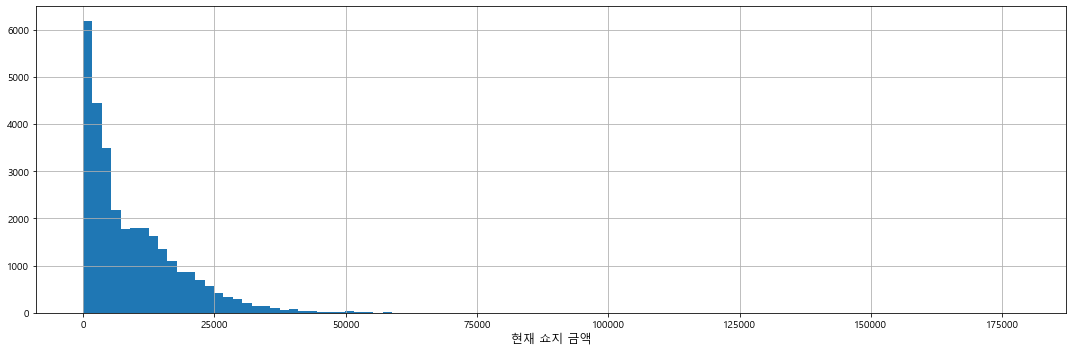

In [37]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
import pandas as pd

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우 맑은 고딕 폰트 경로
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 기존 히스토그램 그리기
plt.figure(figsize=(15, 5))
df.pre_shoji.hist(bins=100)
plt.xlabel('현재 쇼지 금액', fontsize=12)
plt.tight_layout()

### 소지 쇼지 기반 코호트

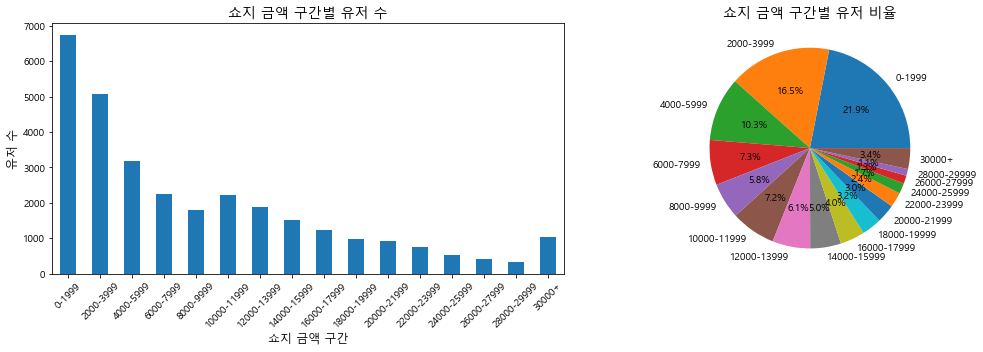

In [38]:
# pre_shoji를 2000 단위로 구간화하고, 3만 이상은 하나의 구간으로 통합
bins = list(range(0, 30001, 2000)) + [float('inf')]
labels = [f'{i}-{i+1999}' for i in range(0, 30000, 2000)] + ['30000+']

# 구간화 및 각 구간별 유저 수 계산
df['pre_shoji_bin'] = pd.cut(df['pre_shoji'], bins=bins, labels=labels, right=False)
bin_counts = df['pre_shoji_bin'].value_counts().sort_index()

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 첫 번째 그래프: 구간별 유저 수 막대 그래프
bin_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('쇼지 금액 구간별 유저 수', fontsize=14)
axes[0].set_xlabel('쇼지 금액 구간', fontsize=12)
axes[0].set_ylabel('유저 수', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# 두 번째 그래프: 구간별 유저 비율 파이 차트
bin_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('쇼지 금액 구간별 유저 비율', fontsize=14)
axes[1].set_ylabel('')

plt.tight_layout()


In [39]:
df['p_date'] = pd.to_datetime(df.p_date)
df.query("p_date >= '2025-01-01'").groupby('pre_shoji_bin').agg({
    'user_id': 'count',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    # 'earn_reward_cnt': 'mean',
    'earn_reward_cnt': 'median',
    })


,user_id,pre_shoji,p_amt,s_amt,s_rto,earn_exchange,earn_reward,earn_reward_cnt
pre_shoji_bin,,,,,,,,
0-1999,6583,771.94106,15990.650160,2566.502355,0.257790,1530.482151,815.594562,15.0
2000-3999,5056,2986.77235,9997.897547,4236.930182,0.573734,2522.818631,2280.920293,31.0
4000-5999,3142,4949.440165,9064.847231,5598.914386,0.753205,4136.798218,2181.560789,30.0
6000-7999,2218,6977.018034,10505.189360,6939.034265,0.783327,5695.602344,2091.983769,31.0
8000-9999,1762,8968.698638,11633.019296,8769.167991,0.830499,7682.579455,2180.109535,34.0
10000-11999,2186,10923.768984,13662.593779,11029.327081,0.866377,10479.830284,1740.87054,29.0
12000-13999,1859,12982.646046,14927.729962,12709.480366,0.896708,12517.381926,2398.091985,44.0
14000-15999,1500,14970.046667,16097.260000,14036.600667,0.919213,14054.159333,2504.737333,44.0
16000-17999,1211,16950.326177,17147.762180,15078.754748,0.918266,15713.365813,2502.037985,45.0


<Axes: >

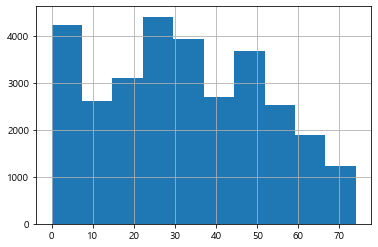

In [40]:
df.query("p_date >= '2025-01-01'").earn_reward_cnt.hist()

In [41]:
# BigQuery에서 가져온 데이터는 때때로 타입 문제가 발생할 수 있습니다.
# 'earn_reward_cnt' 열의 타입을 명시적으로 변환해 보겠습니다.
df['earn_reward_cnt'] = df['earn_reward_cnt'].astype(float)

# 참고: df = bq.query(query).to_dataframe()으로 BigQuery에서 데이터를 가져올 때
# 'unknown type object' 오류가 발생할 수 있습니다. 이는 pandas와 BigQuery 간의
# 데이터 타입 호환성 문제로 인한 것입니다.

In [42]:
df['pre_cash'] = df['pre_cash'].fillna(0)
# 5000 단위로 구간 설정
bins = list(range(0, 30001, 5000)) + [float('inf')]
labels = [f'{i}-{i+4999}' for i in range(0, 30000, 5000)] + ['30000+']

# pre_cash와 pre_shoji 모두 5000 단위로 구간화하고, 3만 이상은 하나의 구간으로 통합
df['pre_cash_bin'] = pd.cut(df['pre_cash'], bins=bins, labels=labels, right=False)
df['pre_shoji_bin'] = pd.cut(df['pre_shoji'], bins=bins, labels=labels, right=False)

In [43]:
df.groupby('pre_cash_bin').agg({
    'user_id': 'count',
    'is_churn': 'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': ['median','mean'],
    })


user_id is_churn      pre_cash     pre_shoji         p_amt  \
               count    count          mean          mean          mean   
pre_cash_bin                                                              
0-4999         18359    18359   1000.503513  12238.922164  14488.442726   
5000-9999       4211     4211   7187.997863   5985.515317  13511.918784   
10000-14999     3620     3620  12222.258840   4841.091713  14080.762431   
15000-19999     2297     2297  17283.696561   4322.490205  14146.538964   
20000-24999     1267     1267  22130.318074   4363.381215  15009.171271   
25000-29999      599      599  27152.624374   4325.517529  16368.080134   
30000+           434      434  36269.089862   4927.052995  19186.405530   

                     s_amt     s_rto earn_exchange  earn_reward  \
                      mean      mean          mean         mean   
pre_cash_bin                                                      
0-4999        10560.104962  0.762693  11126.821559  2181.289994   
5000-9999       6365.50938  0.559119   7103.751128  1690.548801   
10000-14999    7241.831768  0.602044   6727.199448  1884.575967   
15000-19999    5850.470178  0.541981   5187.824989  2040.463648   
20000-24999    5842.856354  0.542518   5090.066298  2129.273875   
25000-29999     5284.15025  0.511987   4662.111853   2142.60601   
30000+         5730.076037  0.515945   4810.571429  2320.705069   

             earn_reward_cnt             
                      median       mean  
pre_cash_bin                             
0-4999                  34.0  34.362275  
5000-9999               27.0  26.543339  
10000-14999             28.0  28.589227  
15000-19999             29.0  29.105355  
20000-24999             29.0  28.557222  
25000-29999             28.0  26.567613  
30000+                  28.0  25.887097

In [44]:
df.groupby('pre_shoji_bin').agg({
    'user_id': 'count',
    'is_churn': 'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': ['median','mean'],
    })


user_id is_churn     pre_cash     pre_shoji         p_amt  \
                count    count         mean          mean          mean   
pre_shoji_bin                                                             
0-4999          13392    13392  9890.531213   2035.696013  12937.554510   
5000-9999        5623     5623  5257.427885   7166.800285  10520.218744   
10000-14999      4867     4867  3439.261968  12280.850832  14514.561331   
15000-19999      2957     2957  2076.401759  17248.104498  17236.070342   
20000-24999      1946     1946  2019.301644  22218.921377  20296.145940   
25000-29999       973      973  1396.059609  27272.252826  22116.998972   
30000+           1033     1033  2364.028074   38274.03485  27595.914811   

                      s_amt     s_rto earn_exchange  earn_reward  \
                       mean      mean          mean         mean   
pre_shoji_bin                                                      
0-4999          3511.099686  0.432879   2147.033303  1553.934961   
5000-9999       7186.884937  0.789337   6038.796906  2036.113463   
10000-14999    12114.012739  0.886141  11812.312102  2112.645161   
15000-19999    15254.692594  0.923280  16225.027054  2526.596212   
20000-24999    18207.320658  0.933428  21414.619733  2831.808325   
25000-29999    20413.100719  0.947934  26512.673176  3375.463515   
30000+         25771.823814  0.953272  44693.116167  4709.725073   

              earn_reward_cnt             
                       median       mean  
pre_shoji_bin                             
0-4999                   26.0  25.329600  
5000-9999                30.0  32.268718  
10000-14999              37.0  34.969180  
15000-19999              45.0  39.502198  
20000-24999              48.0  41.916238  
25000-29999              51.0  47.063720  
30000+                   49.0  40.081317

In [229]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [46]:
# 메모리 사용량 확인
import psutil
import os

# 현재 프로세스의 메모리 사용량 확인
process = psutil.Process(os.getpid())
memory_info = process.memory_info()
print(f"메모리 사용량: {memory_info.rss / 1024 / 1024:.2f} MB")

# 시스템 전체 메모리 상태 확인
system_memory = psutil.virtual_memory()
print(f"시스템 전체 메모리: {system_memory.total / 1024 / 1024 / 1024:.2f} GB")
print(f"사용 가능한 메모리: {system_memory.available / 1024 / 1024 / 1024:.2f} GB")
print(f"메모리 사용률: {system_memory.percent}%")

# CPU 사용량 확인
cpu_percent = psutil.cpu_percent(interval=1)
print(f"CPU 사용률: {cpu_percent}%")

# 각 CPU 코어별 사용량
cpu_percent_per_core = psutil.cpu_percent(interval=1, percpu=True)
for i, percent in enumerate(cpu_percent_per_core):
    print(f"CPU 코어 {i}: {percent}%")

메모리 사용량: 354.93 MB
시스템 전체 메모리: 31.77 GB
사용 가능한 메모리: 13.33 GB
메모리 사용률: 58.0%
CPU 사용률: 11.8%
CPU 코어 0: 16.7%
CPU 코어 1: 0.0%
CPU 코어 2: 12.3%
CPU 코어 3: 0.0%
CPU 코어 4: 10.8%
CPU 코어 5: 1.5%
CPU 코어 6: 23.1%
CPU 코어 7: 1.5%
CPU 코어 8: 13.8%
CPU 코어 9: 0.0%
CPU 코어 10: 0.0%
CPU 코어 11: 10.8%
CPU 코어 12: 20.0%
CPU 코어 13: 10.8%
CPU 코어 14: 1.6%
CPU 코어 15: 7.8%
CPU 코어 16: 23.1%
CPU 코어 17: 1.5%
CPU 코어 18: 4.5%
CPU 코어 19: 32.8%


In [47]:
df.sample(1)

,user_id,join_dt,p_date,cur_shoji,cur_cash,pre_shoji,pre_cash,p_amt,s_amt,s_rto,earn_exchange,earn_exchange_cnt,earn_reward,since_visit_dt,earn_reward_cnt,rnk,is_churn,second_purchase_date,second_cur_shoji,second_pre_shoji,second_pre_cash,second_p_amt,second_s_amt,second_s_rto,second_earn_exchange,second_earn_exchange_cnt,second_earn_reward,second_since_visit_dt,second_earn_reward_cnt,between_earn_exchange,between_earn_exchange_cnt,between_earn_reward,between_earn_reward_cnt,days_between_purchases,pre_shoji_bin,pre_cash_bin
12939,64af7e77-686f-427e-8ac6-4f83530fd2ad,732,2025-02-27,389,3461.0,23654,3461.0,23300.0,23300,1.0,20002,58,3806,58,58.0,1,True,NaT,<NA>,<NA>,NaN,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20000-24999,0-4999


In [48]:
df['is_first_bankrupt'] = df.cur_shoji < 5
df[['is_first_bankrupt','cur_shoji','p_amt','s_amt']].sample(10)

,is_first_bankrupt,cur_shoji,p_amt,s_amt
48109,False,2538,17800.0,17800
42940,False,568,7800.0,7800
19514,True,0,10500.0,1328
666,False,1441,17400.0,870
1741,True,0,15900.0,11387
35319,False,2088,14200.0,14200
1124,False,1365,18300.0,915
27260,False,408,3600.0,3600
41390,False,119,21900.0,1095
5039,False,100,14900.0,2391


In [49]:
df.groupby(['pre_shoji_bin','pre_cash_bin']).agg({
    'join_dt': ['median','mean','min','max'],
    'user_id': 'count',
    'is_first_bankrupt': 'sum',
    'is_churn': 'sum',
    "second_cur_shoji" :'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': ['median','mean','max'],
    }).reset_index()


pre_shoji_bin pre_cash_bin join_dt                         user_id  \
                               median        mean   min   max   count   
0         0-4999       0-4999   567.0  552.971551   108   841    4675   
1         0-4999    5000-9999   572.5  569.094828   151   825    2784   
2         0-4999  10000-14999   578.0  579.934066   173   839    2548   
3         0-4999  15000-19999   582.0  585.881908   254   820    1719   
4         0-4999  20000-24999   585.0  589.784865   293   822     925   
5         0-4999  25000-29999   592.5  598.587558   311   811     434   
6         0-4999       30000+   592.0   597.74183   259   840     306   
7      5000-9999       0-4999   576.0  562.390681   109   823    3906   
8      5000-9999    5000-9999   575.0  562.227006   193   807     511   
9      5000-9999  10000-14999   572.0  573.300216   219   826     463   
10     5000-9999  15000-19999   583.5  593.309091   247   817     330   
11     5000-9999  20000-24999   567.5  584.985577   351   813     208   
12     5000-9999  25000-29999   614.0  608.487179   404   811     117   
13     5000-9999       30000+   596.0  590.465116   336   779      86   
14   10000-14999       0-4999   576.0  569.766294   123   841    3667   
15   10000-14999    5000-9999   582.5  581.667969   175   840     512   
16   10000-14999  10000-14999   585.0  587.513253   290   819     415   
17   10000-14999  15000-19999   585.0  588.801325   296   795     151   
18   10000-14999  20000-24999   588.0  589.189873   391   807      79   
19   10000-14999  25000-29999   588.0      590.75   409   782      28   
20   10000-14999       30000+   613.0  620.666667   402   759      15   
21   15000-19999       0-4999   574.0   575.12333   214   824    2619   
22   15000-19999    5000-9999   564.0  566.722628   312   807     137   
23   15000-19999  10000-14999   566.0  579.510417   326   822      96   
24   15000-19999  15000-19999   619.0      608.44   346   807      50   
25   15000-19999  20000-24999   636.0  623.424242   458   801      33   
26   15000-19999  25000-29999   619.0  570.666667   207   780      12   
27   15000-19999       30000+   580.0  624.444444   445   796       9   
28   20000-24999       0-4999   576.5  575.754706   272   822    1700   
29   20000-24999    5000-9999   592.0  601.859259   323   787     135   
30   20000-24999  10000-14999   615.5  612.274194   382   813      62   
31   20000-24999  15000-19999   618.0  629.461538   446   805      26   
32   20000-24999  20000-24999   640.5       620.6   373   771      10   
33   20000-24999  25000-29999   597.5       612.0   466   787       4   
34   20000-24999       30000+   611.0  590.888889   382   754       9   
35   25000-29999       0-4999   579.0  585.703744   258   821     908   
36   25000-29999    5000-9999   609.0  591.206897   343   807      29   
37   25000-29999  10000-14999   617.0  635.058824   515   786      17   
38   25000-29999  15000-19999   606.0       602.1   412   753      10   
39   25000-29999  20000-24999   661.0  638.571429   574   686       7   
40   25000-29999  25000-29999    <NA>        <NA>  <NA>  <NA>       0   
41   25000-29999       30000+   669.0       669.0   563   775       2   
42        30000+       0-4999   585.5  593.486425   120   840     884   
43        30000+    5000-9999   581.0  593.747573   268   803     103   
44        30000+  10000-14999   641.0  630.105263   484   741      19   
45        30000+  15000-19999   588.0  610.727273   505   761      11   
46        30000+  20000-24999   611.0       651.4   518   799       5   
47        30000+  25000-29999   581.5      584.75   564   612       4   
48        30000+       30000+   561.0       542.0   467   598       7   

   is_first_bankrupt is_churn second_cur_shoji      pre_cash     pre_shoji  \
                 sum      sum            count          mean          mean   
0               2075     2497             1033   1782.311016   2168.705882   
1               1057     1093             105

In [50]:
df.groupby("earn_reward_cnt").agg({
    "user_id":'count',
    "is_first_bankrupt":'sum',
    "is_churn":'sum',
    "second_cur_shoji":'count',
    "earn_reward":'mean',
    "earn_exchange":'mean',
    "p_amt":'mean',
    "s_amt":'mean',
    "s_rto":'mean',
    }).reset_index()


,earn_reward_cnt,user_id,is_first_bankrupt,is_churn,second_cur_shoji,earn_reward,earn_exchange,p_amt,s_amt,s_rto
0,0.0,372,266,335,46,0.0,8221.467742,14846.397849,7058.091398,0.574005
1,1.0,792,276,576,181,478.670455,11391.969697,16759.823232,7850.958333,0.545960
2,2.0,835,243,468,288,719.05988,11854.051497,16808.323353,8035.032335,0.538623
3,3.0,662,178,381,233,605.706949,10228.410876,17082.567976,7321.273414,0.497689
4,4.0,567,168,340,188,398.061728,9648.708995,16937.601411,7028.989418,0.518395
5,5.0,512,157,284,164,642.085938,9112.582031,16575.722656,7166.070312,0.493633
6,6.0,495,143,255,187,745.862626,9897.494949,17335.212121,7351.523232,0.496808
7,7.0,460,153,230,161,577.715217,8657.891304,16011.891304,6643.593478,0.486891
8,8.0,351,97,195,130,732.911681,8047.159544,16536.524217,6653.336182,0.522365
9,9.0,367,124,191,117,645.967302,7020.386921,17089.455041,6309.904632,0.504387


#### 리워드 축적, 첫 구매까지 삼각분포를 이룸. 바로 사용은 이탈하는 특수 케이스로 간주

리워드 획득 횟수 통계:
평균: 31.71
중앙값: 30.00
최소값: 0.00
최대값: 74.00


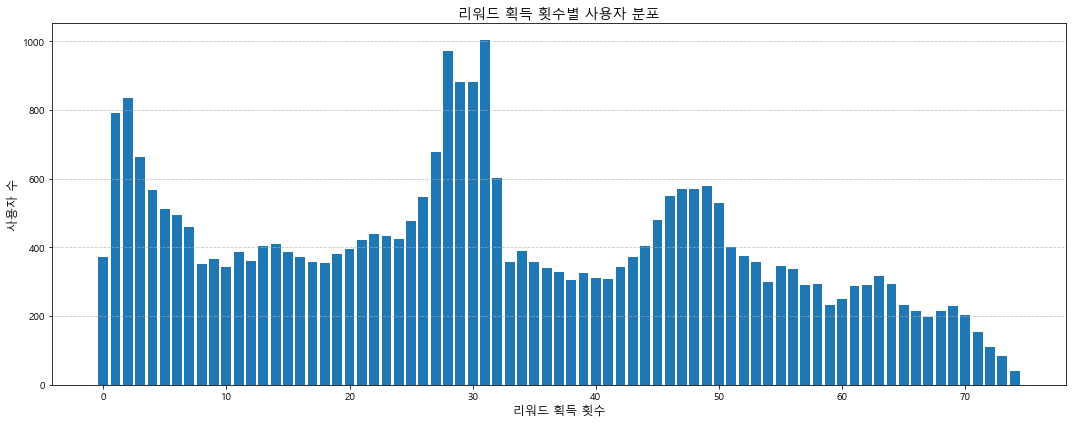

In [51]:
# 리워드 획득 횟수별 사용자 분포 분석
distribution_df = df.groupby("earn_reward_cnt")["user_id"].count().reset_index()
distribution_df = distribution_df.sort_values("earn_reward_cnt")

# 시각화 개선
plt.figure(figsize=(15, 6))
plt.bar(distribution_df["earn_reward_cnt"], distribution_df["user_id"])
plt.title("리워드 획득 횟수별 사용자 분포", fontsize=14)
plt.xlabel("리워드 획득 횟수", fontsize=12)
plt.ylabel("사용자 수", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 기본 통계량 출력
print("리워드 획득 횟수 통계:")
print(f"평균: {df['earn_reward_cnt'].mean():.2f}")
print(f"중앙값: {df['earn_reward_cnt'].median():.2f}")
print(f"최소값: {df['earn_reward_cnt'].min():.2f}")
print(f"최대값: {df['earn_reward_cnt'].max():.2f}")

In [52]:
# 첫 번째 누적 금액 계산
df["first_cum_money"] = df.earn_reward + df.earn_exchange

# 5천 단위로 구간화
df["first_cum_money_bin"] = pd.cut(df["first_cum_money"], 
                                  bins=range(0, df["first_cum_money"].max().astype(int) + 5001, 5000),
                                  labels=[f"{i}-{i+4999}" for i in range(0, df["first_cum_money"].max().astype(int) + 5000, 5000)][:-1],
                                  right=False)

# 구간별 집계
df.groupby("first_cum_money_bin").agg({
    "user_id":'count',
    "pre_cash":'mean',
    "cur_shoji":'mean',
    "is_first_bankrupt":'sum',
    "is_churn":'sum',
    "second_cur_shoji":'count',
    # "earn_reward":'mean',
    "earn_exchange":'mean',
    "p_amt":'mean',
    "s_amt":'mean',
    "s_rto":'mean',
    }).reset_index()


,first_cum_money_bin,user_id,pre_cash,cur_shoji,is_first_bankrupt,is_churn,second_cur_shoji,earn_exchange,p_amt,s_amt,s_rto
0,0-4999,10962,9266.840358,311.766831,4436,4649,4146,703.246488,13378.378033,2547.710363,0.349309
1,5000-9999,5964,5367.981724,592.423374,2503,2655,1691,5186.854628,9853.522803,6485.030349,0.776367
2,10000-14999,5566,5766.796982,1221.333812,1999,2287,1228,10125.145167,13606.413942,11029.246856,0.871461
3,15000-19999,3317,2873.993368,2437.927043,878,1164,646,14726.357251,16587.636418,14431.1224,0.912752
4,20000-24999,2229,3511.782862,4216.988336,428,606,573,19432.10498,19335.302826,17166.509646,0.926267
5,25000-29999,1159,2621.157032,6539.287317,182,278,331,23898.70233,21264.693701,19398.880932,0.940552
6,30000-34999,606,3533.775578,8133.161716,74,129,214,28940.981848,22964.207921,21284.226073,0.948086
7,35000-39999,297,3122.606061,9791.333333,28,75,113,33921.59596,23770.303030,22453.902357,0.955825
8,40000-44999,186,5056.940860,8248.521505,28,34,89,35122.596774,24437.419355,22425.774194,0.939785
9,45000-49999,99,4466.575758,13166.393939,8,19,49,43585.767677,22433.232323,20515.808081,0.942020


In [53]:
df.columns

Index(['user_id', 'join_dt', 'p_date', 'cur_shoji', 'cur_cash', 'pre_shoji',
       'pre_cash', 'p_amt', 's_amt', 's_rto', 'earn_exchange',
       'earn_exchange_cnt', 'earn_reward', 'since_visit_dt', 'earn_reward_cnt',
       'rnk', 'is_churn', 'second_purchase_date', 'second_cur_shoji',
       'second_pre_shoji', 'second_pre_cash', 'second_p_amt', 'second_s_amt',
       'second_s_rto', 'second_earn_exchange', 'second_earn_exchange_cnt',
       'second_earn_reward', 'second_since_visit_dt', 'second_earn_reward_cnt',
       'between_earn_exchange', 'between_earn_exchange_cnt',
       'between_earn_reward', 'between_earn_reward_cnt',
       'days_between_purchases', 'pre_shoji_bin', 'pre_cash_bin',
       'is_first_bankrupt', 'first_cum_money', 'first_cum_money_bin'],
      dtype='object')

In [54]:
# 첫 번째 누적 금액 계산
df["first_cum_money"] = df.earn_reward + df.earn_exchange

# 5천 단위로 구간화
df["first_cum_money_bin"] = pd.cut(df["first_cum_money"], 
                                  bins=range(0, df["first_cum_money"].max().astype(int) + 5001, 5000),
                                  labels=[f"{i}-{i+4999}" for i in range(0, df["first_cum_money"].max().astype(int) + 5000, 5000)][:-1],
                                  right=False)

# 구간별 집계
df.groupby("first_cum_money_bin").agg({
    "user_id":'count',
    # "pre_cash":'mean',
    "cur_shoji":'mean',
    "is_first_bankrupt":'sum',
    "is_churn":'sum',
    # "earn_reward":'mean',
    "earn_exchange":'mean',
    "p_amt":'mean',
    "s_amt":'mean',
    "s_rto":'mean',
    "second_cur_shoji":'count',
    "earn_reward_cnt":'mean',
    "second_earn_reward":'mean',
    "second_earn_exchange":'mean',
    "second_earn_reward_cnt":'mean',
    "second_p_amt":'mean',
    "second_s_amt":'mean',
    "second_s_rto":'mean',
    }).reset_index()


,first_cum_money_bin,user_id,cur_shoji,is_first_bankrupt,is_churn,earn_exchange,p_amt,s_amt,s_rto,second_cur_shoji,earn_reward_cnt,second_earn_reward,second_earn_exchange,second_earn_reward_cnt,second_p_amt,second_s_amt,second_s_rto
0,0-4999,10962,311.766831,4436,4649,703.246488,13378.378033,2547.710363,0.349309,4146,22.652253,1689.42547,6438.411963,26.550169,14934.920405,6978.125422,0.582865
1,5000-9999,5964,592.423374,2503,2655,5186.854628,9853.522803,6485.030349,0.776367,1691,32.101945,2080.908338,8349.563572,28.170313,12145.251331,8944.321703,0.800514
2,10000-14999,5566,1221.333812,1999,2287,10125.145167,13606.413942,11029.246856,0.871461,1228,35.662954,1379.166938,5755.40798,19.934039,11638.021173,8389.149837,0.783160
3,15000-19999,3317,2437.927043,878,1164,14726.357251,16587.636418,14431.1224,0.912752,646,40.449804,1490.896285,2549.027864,21.346749,11441.764706,8144.399381,0.809226
4,20000-24999,2229,4216.988336,428,606,19432.10498,19335.302826,17166.509646,0.926267,573,42.740242,1553.77836,2256.404887,21.382199,12373.298429,9497.270506,0.824398
5,25000-29999,1159,6539.287317,182,278,23898.70233,21264.693701,19398.880932,0.940552,331,47.135462,1715.743202,1758.942598,21.912387,15362.567976,11896.848943,0.840272
6,30000-34999,606,8133.161716,74,129,28940.981848,22964.207921,21284.226073,0.948086,214,44.074257,1746.560748,1975.957944,22.78972,16616.355140,13110.079439,0.860374
7,35000-39999,297,9791.333333,28,75,33921.59596,23770.303030,22453.902357,0.955825,113,41.868687,1455.769912,2154.097345,21.743363,16668.761062,13542.053097,0.886991
8,40000-44999,186,8248.521505,28,34,35122.596774,24437.419355,22425.774194,0.939785,89,27.521505,11974.786517,4402.696629,23.247191,23402.247191,20110.662921,0.859551
9,45000-49999,99,13166.393939,8,19,43585.767677,22433.232323,20515.808081,0.942020,49,32.737374,3698.693878,3102.510204,22.979592,17593.877551,15074.510204,0.884898


In [55]:
df.columns

Index(['user_id', 'join_dt', 'p_date', 'cur_shoji', 'cur_cash', 'pre_shoji',
       'pre_cash', 'p_amt', 's_amt', 's_rto', 'earn_exchange',
       'earn_exchange_cnt', 'earn_reward', 'since_visit_dt', 'earn_reward_cnt',
       'rnk', 'is_churn', 'second_purchase_date', 'second_cur_shoji',
       'second_pre_shoji', 'second_pre_cash', 'second_p_amt', 'second_s_amt',
       'second_s_rto', 'second_earn_exchange', 'second_earn_exchange_cnt',
       'second_earn_reward', 'second_since_visit_dt', 'second_earn_reward_cnt',
       'between_earn_exchange', 'between_earn_exchange_cnt',
       'between_earn_reward', 'between_earn_reward_cnt',
       'days_between_purchases', 'pre_shoji_bin', 'pre_cash_bin',
       'is_first_bankrupt', 'first_cum_money', 'first_cum_money_bin'],
      dtype='object')

In [56]:
# float 타입 오류 수정
# NaN 값을 제외하고 최대값 계산
max_value = df["second_p_amt"].dropna().max()
if pd.notna(max_value):
    max_int = int(max_value) + 5001
    # 레이블 개수는 구간 경계 개수보다 하나 적어야 함
    bins = list(range(0, max_int, 5000))
    labels = [f"{i}-{i+4999}" for i in range(0, max_int, 5000) if i < max_int - 5000]
    df["second_p_amt_bin"] = pd.cut(df["second_p_amt"], 
                                    bins=bins,
                                    labels=labels,
                                    right=False)
else:
    # 데이터가 없는 경우 빈 카테고리 생성
    df["second_p_amt_bin"] = pd.Categorical([])

df.groupby("second_p_amt_bin").agg({
    "user_id":'count',
    "second_pre_shoji":'mean',
    "second_pre_cash":'mean',
    "second_p_amt":'mean',
    "second_s_amt":'mean',
    "second_s_rto":'mean',
    "second_earn_reward":'mean',
    "second_earn_exchange":'mean',
    "second_earn_reward_cnt":'mean',
    }).reset_index()

,second_p_amt_bin,user_id,second_pre_shoji,second_pre_cash,second_p_amt,second_s_amt,second_s_rto,second_earn_reward,second_earn_exchange,second_earn_reward_cnt
0,0-4999,1541,5202.079818,2848.144737,4031.726152,3512.188838,0.872940,1586.045425,2215.791694,24.689812
1,5000-9999,2285,7791.717287,3684.197866,7905.045952,5919.422319,0.761133,1692.902407,4243.960613,25.225383
2,10000-14999,2570,9704.250584,4632.781618,12394.630350,8491.506615,0.685533,1704.624125,5788.266537,24.868482
3,15000-19999,1428,12836.185574,4193.262598,17392.296919,11949.851541,0.691064,1687.912465,8180.260504,24.880952
4,20000-24999,575,15012.050435,4345.664311,22241.408696,14079.283478,0.633130,1682.777391,10010.688696,24.817391
5,25000-29999,356,15909.061798,5063.095930,27690.028090,15447.581461,0.560478,2445.985955,9975.735955,27.789326
6,30000-34999,202,16031.851485,5274.955000,32659.900990,15749.564356,0.483020,3054.366337,8795.960396,24.361386
7,35000-39999,124,16184.483871,6895.764228,37791.532258,15839.072581,0.417903,3613.33871,8648.370968,22.459677
8,40000-44999,50,16156.22,8588.479167,42512.000000,16009.88,0.379600,4996.0,6558.28,17.36
9,45000-49999,32,17925.15625,7515.833333,47903.125000,18232.90625,0.376563,11490.25,5734.71875,11.4375


In [62]:
df.columns

Index(['user_id', 'join_dt', 'p_date', 'cur_shoji', 'cur_cash', 'pre_shoji',
       'pre_cash', 'p_amt', 's_amt', 's_rto', 'earn_exchange',
       'earn_exchange_cnt', 'earn_reward', 'since_visit_dt', 'earn_reward_cnt',
       'rnk', 'is_churn', 'second_purchase_date', 'second_cur_shoji',
       'second_pre_shoji', 'second_pre_cash', 'second_p_amt', 'second_s_amt',
       'second_s_rto', 'second_earn_exchange', 'second_earn_exchange_cnt',
       'second_earn_reward', 'second_since_visit_dt', 'second_earn_reward_cnt',
       'between_earn_exchange', 'between_earn_exchange_cnt',
       'between_earn_reward', 'between_earn_reward_cnt',
       'days_between_purchases', 'pre_shoji_bin', 'pre_cash_bin',
       'is_first_bankrupt', 'first_cum_money', 'first_cum_money_bin',
       'second_p_amt_bin'],
      dtype='object')

In [173]:
# 첫구매 시 쇼지 and 재산 5000미만 유저 필터링
tg = df.query("pre_shoji_bin == '0-4999' & pre_cash_bin == '0-4999'")[[
    'user_id','pre_shoji','pre_cash', 'cur_shoji','cur_cash',  'p_amt','s_amt','s_rto']]

tg['shoji_spent'] = tg['pre_shoji'] - tg['cur_shoji']
tg['cash_spent'] = tg['pre_cash'] - tg['cur_cash']


tg.user_id.nunique()


4675

### 첫구매 시 재산 적었던 유저 or 전체유저 필터링하여 분석 
- 첫 구매시 쇼지 <= 5000 and 캐시가 <= 5000인 유저 필터링
- 해당 타겟의 전체 구매 평균 통계값 도출하여 분석

In [488]:
# 리스트의 요소들을 쉼표로 구분된 문자열로 변환
user_ids_str = ", ".join([f"'{user_id}'" for user_id in tg.user_id.tolist()])

# 저재산 유저
tg_query_1 = """
    SELECT 
        user_id, register_dt, pre_shoji, pre_cash, current_shoji, current_cash, purchase, earn_total, spend_total, 
        spend_use, earn_reward,earn_cash_direct_exchange, earn_exchange, earn_recall
    FROM dm.agg_user_cash_daily
    WHERE 1=1 
    and user_id IN ({})
        and purchase is not null
        and register_dt > "2024-12-31"
""".format(user_ids_str)
# 전체 유저
tg_query_2 = """
    SELECT 
        user_id, register_dt, pre_shoji, pre_cash, current_shoji, current_cash, purchase, earn_total, spend_total, 
        spend_use, earn_reward,earn_cash_direct_exchange, earn_exchange, earn_recall
    FROM dm.agg_user_cash_daily
    WHERE 1=1 
        and purchase is not null
        and register_dt > "2024-12-31"
""".format(user_ids_str)

tg_df = bq.query(tg_query_2).to_dataframe()

tg_df.head()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


,user_id,register_dt,pre_shoji,pre_cash,current_shoji,current_cash,purchase,earn_total,spend_total,spend_use,earn_reward,earn_cash_direct_exchange,earn_exchange,earn_recall
0,63d021b6-fca9-4f7f-913c-c6d4ae874190,2025-02-16,4136,389.0,400,89.0,4200.0,464,4200,4200,164,0,300,0
1,51e4cb6e-496c-4e03-a46f-82d2f1ada157,2025-02-12,3753,142.0,1708,142.0,2100.0,55,2100,2100,55,0,0,0
2,3f114d41-268d-445e-aa23-77c4fc7cf8a4,2025-03-19,30045,89.0,14767,89.0,15300.0,22,15300,15300,22,0,0,0
3,f8862fd6-1bdc-4bf7-aaee-1dba8f7bbb5d,2025-02-04,793,18548.0,793,13878.0,93400.0,4670,4670,4670,0,4670,0,0
4,f8862fd6-1bdc-4bf7-aaee-1dba8f7bbb5d,2025-03-07,933,13878.0,933,12188.0,33800.0,1690,1690,0,0,1690,0,0


In [489]:
tg_df.iloc[:,2:] = tg_df.iloc[:,2:].astype(float)
tg_df['earn_exchange'] = tg_df['earn_exchange'] + tg_df['earn_cash_direct_exchange']
tg_df['s_rto'] = round(
    (tg_df['spend_total']  / tg_df['purchase']).where(
        tg_df['earn_recall'] > tg_df['spend_use'],
        (tg_df['spend_use'] - tg_df['earn_recall']) / tg_df['purchase']
    ), 2)
# cash_rto 계산
# cash_rto 계산 - inf 처리 및 최대값 1 제한
tg_df['cash_rto'] = (tg_df['earn_exchange'] / tg_df['spend_total']).where(
    tg_df['earn_recall'] > tg_df['spend_use'],
    tg_df['earn_exchange'] / (tg_df['spend_use'] - tg_df['earn_recall'])
).clip(upper=1.0).fillna(1.0).round(2)
tg_df.groupby('user_id').agg({
    'purchase':'count',
    'earn_total':'sum',
    'spend_use':'sum',
    'earn_reward':'sum',
    'earn_exchange':'sum',
    's_rto':'mean',
    'cash_rto':'mean',
    }).reset_index().head()

tg_df['cash_direct_rto'] = (tg_df['earn_cash_direct_exchange'] / tg_df['spend_total']).clip(upper=1.0)

tg_df[(tg_df['s_rto'] <= 0.06) & (tg_df['s_rto'] >= 0.04)].cash_direct_rto.mean()
tg_df['s_rto'] = tg_df['s_rto'].clip(lower=0.0)
tg_df['s_rto'] = tg_df['s_rto'].clip(upper=1)

<ipython-input-489-42021dd14ca1>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tg_df.iloc[:,2:] = tg_df.iloc[:,2:].astype(float)


In [490]:
tg_df.groupby(s_rto_bins)['cash_direct_rto'].mean()

s_rto
(-0.001, 0.05]    0.135299
(0.05, 0.1]       0.137766
(0.1, 0.15]       0.153000
(0.15, 0.2]       0.135493
(0.2, 0.25]       0.128247
(0.25, 0.3]       0.109749
(0.3, 0.35]       0.146940
(0.35, 0.4]       0.154112
(0.4, 0.45]       0.108878
(0.45, 0.5]       0.166291
(0.5, 0.55]       0.129531
(0.55, 0.6]       0.103505
(0.6, 0.65]       0.097635
(0.65, 0.7]       0.130220
(0.7, 0.75]       0.164402
(0.75, 0.8]       0.095770
(0.8, 0.85]       0.184588
(0.85, 0.9]       0.155602
(0.9, 0.95]       0.151613
(0.95, 1.0]       0.131848
Name: cash_direct_rto, dtype: float64

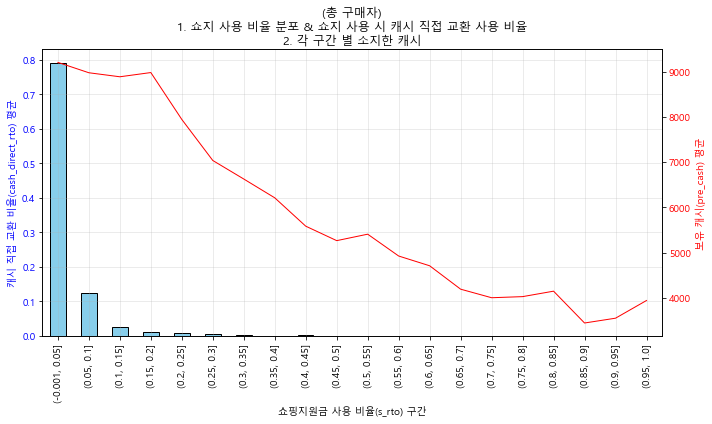

In [491]:
# s_rto를 50개 구간으로 나누고 각 구간별 cash_direct_rto 평균과 pre_cash 평균 계산
fig, ax1 = plt.subplots(figsize=(10, 6))

# s_rto를 50개 구간으로 나누기
s_rto_bins = pd.cut(tg_df.s_rto, bins=20)

# 각 구간별 cash_direct_rto 평균 계산
s_rto_cash_direct_avg = tg_df.groupby(s_rto_bins)['cash_direct_rto'].mean()

# 각 구간별 pre_cash 평균 계산
s_rto_pre_cash_avg = tg_df.groupby(s_rto_bins)['pre_cash'].mean()

# 첫 번째 y축에 cash_direct_rto 평균 그래프 그리기
s_rto_cash_direct_avg.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_xlabel('쇼핑지원금 사용 비율(s_rto) 구간')
ax1.set_ylabel('캐시 직접 교환 비율(cash_direct_rto) 평균', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 두 번째 y축 생성하여 pre_cash 평균 라인 그래프 추가
ax2 = ax1.twinx()
s_rto_pre_cash_avg.plot(kind='line', ax=ax2, color='red', linestyle='-', linewidth=1)
ax2.set_ylabel('보유 캐시(pre_cash) 평균', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('(총 구매자)\n'
          '1. 쇼지 사용 비율 분포 & 쇼지 사용 시 캐시 직접 교환 사용 비율\n'
          '2. 각 구간 별 소지한 캐시')
# plt.title('(첫구매 시 쇼지+캐시 5000미만)\n'
#           '1. 쇼지 사용 비율 분포 & 쇼지 사용 시 캐시 직접 교환 사용 비율\n'
#           '2. 각 구간 별 소지한 캐시')
# plt.text(0.5, 0.95, '5% 사용 구간에 캐시 직접 교환 비율이 높은 경향', 
#          ha='center', va='center',style='italic', transform=plt.gca().transAxes, fontsize=12)
plt.xticks(rotation=90)
ax1.grid(True, alpha=0.3)
plt.tight_layout()


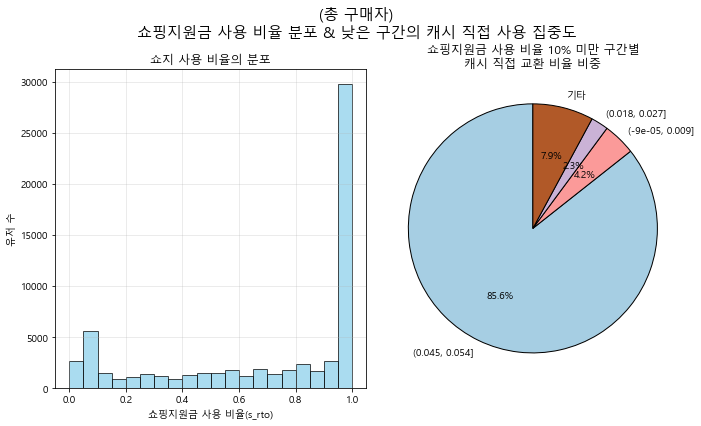

In [492]:
# s_rto와 cash_direct_rto 관계 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# s_rto 히스토그램
ax1.hist(tg_df.s_rto, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('쇼핑지원금 사용 비율(s_rto)')
ax1.set_ylabel('유저 수')
ax1.set_title('쇼지 사용 비율의 분포')
ax1.grid(True, alpha=0.3)

# s_rto가 10% 미만인 구간에서의 cash_direct_rto 분석
low_s_rto_users = tg_df[tg_df.s_rto < 0.1]
s_rto_bins_low = pd.cut(low_s_rto_users.s_rto, bins=10)
cash_direct_by_s_rto = low_s_rto_users.groupby(s_rto_bins_low)['cash_direct_rto'].mean()

# 전체 구간 대비 각 구간의 cash_direct_rto 비중을 파이 차트로 표현
total_cash_direct = low_s_rto_users['cash_direct_rto'].sum()
cash_direct_proportion = low_s_rto_users.groupby(s_rto_bins_low)['cash_direct_rto'].sum() / total_cash_direct

# 파이 차트 그리기
# 상위 3개 미만 기타로 통합
sorted_proportions = cash_direct_proportion.sort_values(ascending=False)
top_3 = sorted_proportions.iloc[:3]
others = pd.Series({'기타': sorted_proportions.iloc[3:].sum()})
combined_proportions = pd.concat([top_3, others])

combined_proportions.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90, 
                         colors=plt.cm.Paired(np.linspace(0, 1, len(combined_proportions))),
                         wedgeprops={'edgecolor': 'black', 'linewidth': 1})
ax2.set_ylabel('')  # y 레이블 제거
ax2.set_title('쇼핑지원금 사용 비율 10% 미만 구간별\n캐시 직접 교환 비율 비중')

plt.suptitle('(총 구매자)\n'
             '쇼핑지원금 사용 비율 분포 & 낮은 구간의 캐시 직접 사용 집중도', fontsize=15)
# plt.suptitle('(첫구매 시 쇼지+캐시 5000미만)\n'
#              '쇼핑지원금 사용 비율 분포 & 낮은 구간의 캐시 직접 사용 집중도', fontsize=15)
plt.tight_layout()

In [493]:
# 전체 
pd.cut(tg_df.s_rto, bins=20).value_counts()

(0.95, 1.0]       29784
(-0.001, 0.05]     7430
(0.9, 0.95]        2225
(0.85, 0.9]        2097
(0.8, 0.85]        2029
(0.75, 0.8]        1785
(0.7, 0.75]        1669
(0.65, 0.7]        1604
(0.45, 0.5]        1546
(0.6, 0.65]        1507
(0.55, 0.6]        1498
(0.4, 0.45]        1386
(0.5, 0.55]        1348
(0.3, 0.35]        1219
(0.1, 0.15]        1186
(0.35, 0.4]        1179
(0.25, 0.3]        1168
(0.2, 0.25]        1136
(0.15, 0.2]        1087
(0.05, 0.1]        1072
Name: s_rto, dtype: int64

소비 비율 구간별 유저 수:
(-0.002, 0.1]    45937
(0.1, 0.2]        1866
(0.2, 0.3]        1327
(0.3, 0.4]         860
(0.4, 0.5]         770
(0.5, 0.6]         755
(0.6, 0.7]         786
(0.7, 0.8]        1032
(0.8, 0.9]        1020
(0.9, 1.0]        9602
Name: cash_rto, dtype: int64


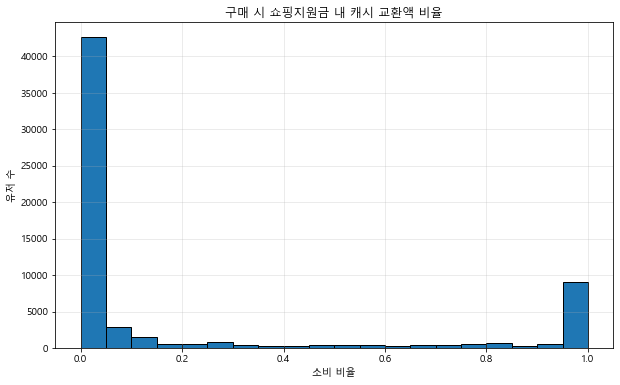

In [494]:
# s_rto 비율에 대한 히스토그램 생성
plt.figure(figsize=(10, 6))
plt.hist(tg_df.cash_rto, bins=20, edgecolor='black')
plt.title('소비 비율(s_rto) 분포')
plt.xlabel('소비 비율')
plt.ylabel('유저 수')
plt.title('구매 시 쇼핑지원금 내 캐시 교환액 비율')
plt.grid(True, alpha=0.3)

# 각 비율 구간별 유저 수 계산
cash_rto_counts = tg_df.cash_rto.value_counts(bins=10).sort_index()
print("소비 비율 구간별 유저 수:")
print(cash_rto_counts)

캐시 교환 비율 구간별 유저 수:
(-0.002, 0.1]    45937
(0.1, 0.2]        1866
(0.2, 0.3]        1327
(0.3, 0.4]         860
(0.4, 0.5]         770
(0.5, 0.6]         755
(0.6, 0.7]         786
(0.7, 0.8]        1032
(0.8, 0.9]        1020
(0.9, 1.0]        9602
Name: cash_rto, dtype: int64


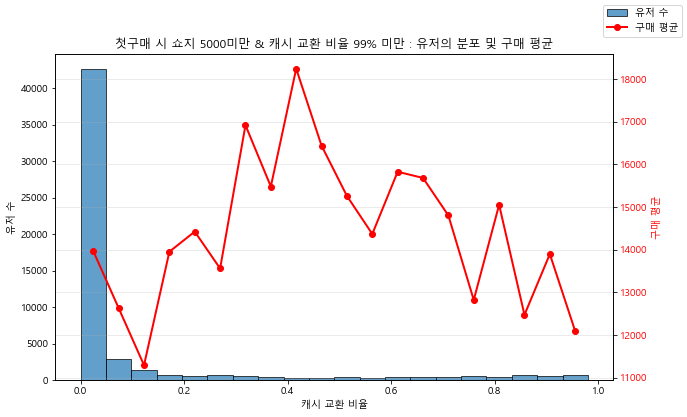

In [495]:
# cash_rto 비율과 purchase 평균을 히스토그램으로 표현
fig, ax1 = plt.figure(figsize=(10, 6)), plt.gca()

# cash_rto 히스토그램
n, bins, patches = ax1.hist(tg_df.query("cash_rto < 0.99").cash_rto, bins=20, edgecolor='black', alpha=0.7, label='유저 수')

# 두 번째 y축 생성
ax2 = ax1.twinx()

# 각 구간별 purchase 평균 계산
purchase_means = []
for i in range(len(bins)-1):
    mask = (tg_df.cash_rto >= bins[i]) & (tg_df.cash_rto < bins[i+1]) & (tg_df.cash_rto < 0.99)
    purchase_means.append(tg_df[mask].purchase.mean())

# purchase 평균 선 그래프 추가
bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
ax2.plot(bin_centers, purchase_means, color='red', marker='o', linestyle='-', linewidth=2, label='구매 평균')

# 그래프 설정
ax1.set_xlabel('캐시 교환 비율')
ax1.set_ylabel('유저 수')
ax2.set_ylabel('구매 평균', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('첫구매 시 쇼지 5000미만 & 캐시 교환 비율 99% 미만 : 유저의 분포 및 구매 평균')
fig.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# 각 비율 구간별 유저 수 계산
cash_rto_counts = tg_df.cash_rto.value_counts(bins=10).sort_index()
print("캐시 교환 비율 구간별 유저 수:")
print(cash_rto_counts)

캐시 교환 비율 구간별 유저 수:
(-0.002, 0.1]    45937
(0.1, 0.2]        1866
(0.2, 0.3]        1327
(0.3, 0.4]         860
(0.4, 0.5]         770
(0.5, 0.6]         755
(0.6, 0.7]         786
(0.7, 0.8]        1032
(0.8, 0.9]        1020
(0.9, 1.0]        9602
Name: cash_rto, dtype: int64


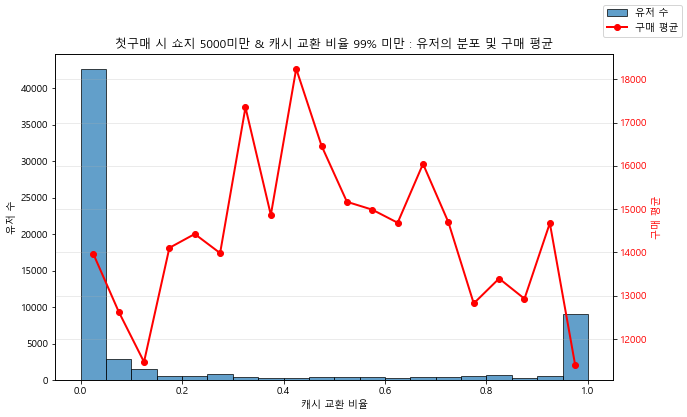

In [496]:
# cash_rto 비율과 purchase 평균을 히스토그램으로 표현
fig, ax1 = plt.figure(figsize=(10, 6)), plt.gca()

# cash_rto 히스토그램
n, bins, patches = ax1.hist(tg_df.cash_rto, bins=20, edgecolor='black', alpha=0.7, label='유저 수')

# 두 번째 y축 생성
ax2 = ax1.twinx()

# 각 구간별 purchase 평균 계산
purchase_means = []
for i in range(len(bins)-1):
    mask = (tg_df.cash_rto >= bins[i]) & (tg_df.cash_rto < bins[i+1])
    purchase_means.append(tg_df[mask].purchase.mean())

# purchase 평균 선 그래프 추가
bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
ax2.plot(bin_centers, purchase_means, color='red', marker='o', linestyle='-', linewidth=2, label='구매 평균')

# 그래프 설정
ax1.set_xlabel('캐시 교환 비율')
ax1.set_ylabel('유저 수')
ax2.set_ylabel('구매 평균', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('첫구매 시 쇼지 5000미만 & 캐시 교환 비율 99% 미만 : 유저의 분포 및 구매 평균')
fig.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# 각 비율 구간별 유저 수 계산
cash_rto_counts = tg_df.cash_rto.value_counts(bins=10).sort_index()
print("캐시 교환 비율 구간별 유저 수:")
print(cash_rto_counts)

쇼지사용 비율 구간별 유저 수:
(-0.002, 0.1]     8502
(0.1, 0.2]        2273
(0.2, 0.3]        2304
(0.3, 0.4]        2398
(0.4, 0.5]        2932
(0.5, 0.6]        2846
(0.6, 0.7]        3111
(0.7, 0.8]        3454
(0.8, 0.9]        4126
(0.9, 1.0]       32009
Name: s_rto, dtype: int64


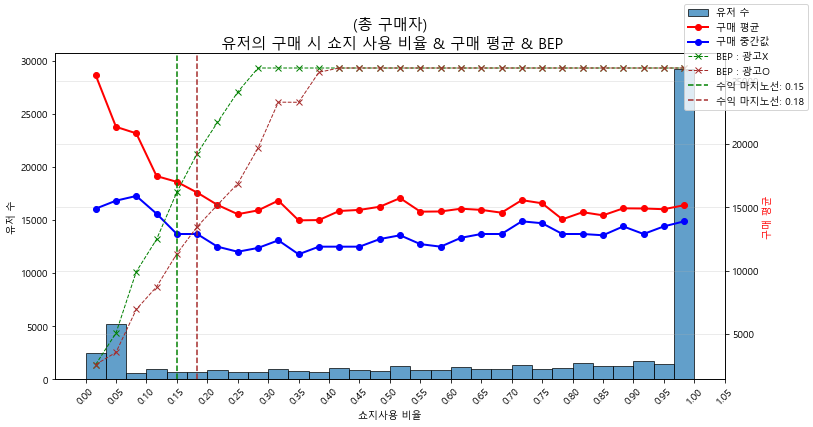

In [497]:
# s_rto 비율과 purchase 평균을 히스토그램으로 표현
fig, ax1 = plt.figure(figsize=(12, 6)), plt.gca()

# s_rto 히스토그램
n, bins, patches = ax1.hist(tg_df.s_rto, bins=30, edgecolor='black', alpha=0.7, label='유저 수')
plt.xticks(rotation=45)
ax1.set_xticks(np.arange(0, 1.1, 0.05))  # x축 눈금을 0부터 1까지 0.05 간격으로 설정

# 두 번째 y축 생성
ax2 = ax1.twinx()

# 각 구간별 purchase 평균 계산
purchase_means = []
for i in range(len(bins)-1):
    mask = (tg_df.s_rto >= bins[i]) & (tg_df.s_rto < bins[i+1])
    purchase_means.append(tg_df[mask].purchase.mean())
purchase_medians = []
for i in range(len(bins)-1):
    mask = (tg_df.s_rto >= bins[i]) & (tg_df.s_rto < bins[i+1])
    purchase_medians.append(tg_df[mask].purchase.median())

# purchase 평균 선 그래프 추가
bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
ax2.plot(bin_centers, purchase_means, color='red', marker='o', linestyle='-', linewidth=2, label='구매 평균')
ax2.plot(bin_centers, purchase_medians, color='blue', marker='o', linestyle='-', linewidth=2, label='구매 중간값')

### 쇼지 사용액 당 bep 그래프 추가
import numpy as np
shoji_purchase_means = np.multiply(purchase_means, bins[:len(purchase_means)])
shoji_price_cut = np.multiply(shoji_purchase_means, 7.143)
shoji_price_cut = np.minimum(np.maximum(shoji_price_cut, 2600), 26000)
# 광고 O
shoji_purchase_means_ad = np.multiply(purchase_means, bins[:len(purchase_means)])
shoji_price_cut_ad = np.multiply(shoji_purchase_means_ad, 5.0)
shoji_price_cut_ad = np.minimum(np.maximum(shoji_price_cut_ad, 2600), 26000)
# ax2 축에 쇼지 사용액 당 bep 그래프 추가
ax2.plot(bin_centers, shoji_price_cut, color='green', marker='x', linestyle='--', linewidth=1, label='BEP : 광고X')
ax2.plot(bin_centers, shoji_price_cut_ad, color='brown', marker='x', linestyle='--', linewidth=1, label='BEP : 광고O')

# purchase_means < shoji_price_cut 조건을 만족하는 최댓값 찾기
valid_indices = [i for i in range(len(purchase_means)) if purchase_means[i] > shoji_price_cut[i]]
if valid_indices:
    max_index = max(valid_indices)
    # 해당 위치에 수직선 추가
    ax2.axvline(x=bin_centers[max_index], color='green', linestyle='--', linewidth=1.5, 
                label=f'수익 마지노선: {bin_centers[max_index]:.2f}')
valid_indices_ad = [i for i in range(len(purchase_means)) if purchase_means[i] > shoji_price_cut_ad[i]]
if valid_indices_ad:
    max_index = max(valid_indices_ad)
    # 해당 위치에 수직선 추가
    ax2.axvline(x=bin_centers[max_index], color='brown', linestyle='--', linewidth=1.5, 
                label=f'수익 마지노선: {bin_centers[max_index]:.2f}')

# 그래프 설정
ax1.set_xlabel('쇼지사용 비율')
ax1.set_ylabel('유저 수')
ax2.set_ylabel('구매 평균', color='red')
ax2.tick_params(axis='y', labelcolor='black')

# plt.title('(첫 구매 시 쇼지+캐시 5000미만)\n'
        #   ' 유저의 구매 시 쇼지 사용 비율 & 구매 평균 & BEP', fontsize=15)
plt.title('(총 구매자)\n'
          ' 유저의 구매 시 쇼지 사용 비율 & 구매 평균 & BEP', fontsize=15)
fig.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# 각 비율 구간별 유저 수 계산
s_rto_counts = tg_df.s_rto.value_counts(bins=10).sort_index()
print("쇼지사용 비율 구간별 유저 수:")
print(s_rto_counts) 

In [384]:
[i for i in range(len(purchase_means)) if purchase_means[i] > shoji_price_cut[i]]

[0, 1, 2, 3, 4]

### 12/31 이래로, 총 재산이 별로 없을떄 유저들의 구매 패턴 

In [289]:
## 구매당시 5000원 미만 재산 유저들들
tg_query = """
    with raw as
    (select user_id, register_dt, current_shoji, current_cash, purchase, earn_total, spend_total, spend_use, earn_reward,earn_cash_direct_exchange, earn_exchange, earn_recall, pre_shoji + pre_cash as pre_asset
    from `dm.agg_user_cash_daily`
    where 1=1
    and register_dt > "2024-12-31"
    and purchase is not null)

    select *
    from raw
    where pre_asset <= 2000
"""
tg_df_2 = bq.query(tg_query).to_dataframe()

tg_df_2.head()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


,user_id,register_dt,current_shoji,current_cash,purchase,earn_total,spend_total,spend_use,earn_reward,earn_cash_direct_exchange,earn_exchange,earn_recall,pre_asset
0,5376c482-e482-421c-b52f-54c4d1625afb,2025-03-08,459,2.0,9900.0,172,95,95,28,95,0,0,479.0
1,a21a6bb5-d9c1-416c-b8a4-057b3a7b17b0,2025-03-17,1166,251.0,7500.0,413,375,375,38,375,0,0,1754.0
2,3e73c5c4-5043-4ae1-8913-2fabdb46b208,2025-01-18,65,37.0,8900.0,29,0,0,28,0,1,0,74.0
3,5551a3b2-9c56-4fa3-b7d6-989cc2be3641,2025-03-18,109,548.0,10900.0,545,545,545,0,545,0,0,1202.0
4,24d8bedb-638d-4115-96ad-ed920964d499,2025-04-09,0,15.0,3900.0,0,1066,1066,0,0,0,0,1081.0


In [290]:
tg_df_2.iloc[:,2:] = tg_df_2.iloc[:,2:].astype(float)
tg_df_2['earn_exchange'] = tg_df_2['earn_exchange'] + tg_df_2['earn_cash_direct_exchange']
tg_df_2['s_rto'] = round(
    (tg_df_2['spend_total']  / tg_df_2['purchase']).where(
        tg_df_2['earn_recall'] > tg_df_2['spend_use'],
        (tg_df_2['spend_use'] - tg_df_2['earn_recall']) / tg_df_2['purchase']
    ), 2)
# cash_rto 계산
# cash_rto 계산 - inf 처리 및 최대값 1 제한
tg_df_2['cash_rto'] = (tg_df_2['earn_exchange'] / tg_df_2['spend_total']).where(
    tg_df_2['earn_recall'] > tg_df_2['spend_use'],
    tg_df_2['earn_exchange'] / (tg_df_2['spend_use'] - tg_df_2['earn_recall'])
).clip(upper=1.0).fillna(1.0).round(2)
tg_df_2.groupby('user_id').agg({
    'purchase':'count',
    'earn_total':'sum',
    'spend_use':'sum',
    'earn_reward':'sum',
    'earn_exchange':'sum',
    's_rto':'mean',
    'cash_rto':'mean',
    }).reset_index().head()


<ipython-input-290-e9469de1a995>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tg_df_2.iloc[:,2:] = tg_df_2.iloc[:,2:].astype(float)


,user_id,purchase,earn_total,spend_use,earn_reward,earn_exchange,s_rto,cash_rto
0,000ab120-154e-433c-8030-6313fbe8d5a3,1,1046.0,1185.0,10.0,1000.0,0.33,0.84
1,00513524-5e65-480c-8c7d-3d09595b0365,1,897.0,890.0,7.0,890.0,0.05,1.00
2,008430f2-c7e1-450d-9a32-85da44f4130c,1,997.0,995.0,2.0,995.0,0.05,1.00
3,00a5f195-9af9-4ecd-8372-656f0a4fc97e,1,0.0,1372.0,0.0,0.0,0.04,0.00
4,00c34e33-3302-40b1-89f3-f0cdfea2eb5d,1,64.0,102.0,64.0,0.0,0.01,0.00


쇼지사용 비율 구간별 유저 수:
(-0.00201, 0.0505]    1169
(0.0505, 0.101]        152
(0.101, 0.152]         113
(0.152, 0.202]          56
(0.202, 0.252]          44
(0.252, 0.303]          56
(0.303, 0.354]          39
(0.354, 0.404]          36
(0.404, 0.454]          29
(0.454, 0.505]          24
(0.505, 0.556]           7
(0.556, 0.606]           0
(0.606, 0.657]           1
(0.657, 0.707]           2
(0.707, 0.758]           0
(0.758, 0.808]           1
(0.808, 0.858]           1
(0.858, 0.909]           0
(0.909, 0.96]            0
(0.96, 1.01]            41
Name: s_rto, dtype: int64


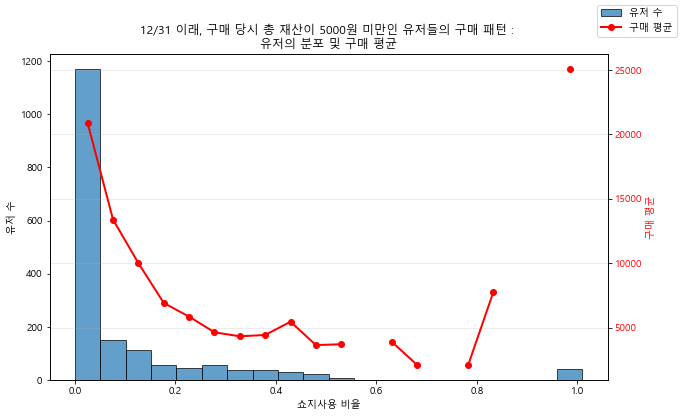

In [291]:
# s_rto 비율과 purchase 평균을 히스토그램으로 표현
fig, ax1 = plt.figure(figsize=(10, 6)), plt.gca()

# s_rto 히스토그램
n, bins, patches = ax1.hist(tg_df_2.s_rto, bins=20, edgecolor='black', alpha=0.7, label='유저 수')

# 두 번째 y축 생성
ax2 = ax1.twinx()

# 각 구간별 purchase 평균 계산
purchase_means = []
for i in range(len(bins)-1):
    mask = (tg_df_2.s_rto >= bins[i]) & (tg_df_2.s_rto < bins[i+1])
    purchase_means.append(tg_df_2[mask].purchase.mean())

# purchase 평균 선 그래프 추가
bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
ax2.plot(bin_centers, purchase_means, color='red', marker='o', linestyle='-', linewidth=2, label='구매 평균')

# 그래프 설정
ax1.set_xlabel('쇼지사용 비율')
ax1.set_ylabel('유저 수')
ax2.set_ylabel('구매 평균', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('12/31 이래, 구매 당시 총 재산이 5000원 미만인 유저들의 구매 패턴 : \n유저의 분포 및 구매 평균')
fig.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# 각 비율 구간별 유저 수 계산
s_rto_counts = tg_df_2.s_rto.value_counts(bins=20).sort_index()
print("쇼지사용 비율 구간별 유저 수:")
print(s_rto_counts)